In [1]:
import os
from glob import glob
import hashlib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from copy import deepcopy
import ipynbname
import matplotlib.pyplot as plt
import shap
from datetime import datetime
import re

# Constants
EXPERIMENT_NAME = "nursing_home"
DATA_PATH = f"..{os.sep}data{os.sep}"

In [2]:
current_time = datetime.now()
print("Current time is:",current_time)

nb_fname = ipynbname.name()
print("File:",nb_fname)

experiment_number = int(re.findall(r'\d+', nb_fname)[0])
print(f"Experiment Number: {experiment_number}")  # Output: 01

Current time is: 2024-12-05 21:52:13.473931
File: machine_learning_experiment09
Experiment Number: 9


In [3]:
# Function to generate a consistent hash number for a given file name
def generate_hash_number(file_name):
    """
    Generates a consistent hash number based on the file name.
    
    Args:
        file_name (str): The file name to hash.
    
    Returns:
        int: A 32-bit hash number.
    """
    # Create an MD5 hash object
    hash_obj = hashlib.md5()
    
    # Update the hash object with the file name, encoded to bytes
    hash_obj.update(file_name.encode())

    # Convert the hash to an integer and ensure the range fits 32-bit
    return int(hash_obj.hexdigest(), 16) % (2**32)

# Generate experiment seed from experiment name
initial_seed = generate_hash_number(EXPERIMENT_NAME)
print(f"Experiment Name: {EXPERIMENT_NAME}, Initial Seed: {initial_seed}")

Experiment Name: nursing_home, Initial Seed: 127573839


In [4]:
# Set the seed for reproducibility
np.random.seed(initial_seed)

# Generate a list of 5 random integers in the range of 32-bit integers
random_integers_list = np.random.randint(low=0, high=2**31 - 1, size=10).tolist()
print("Random Integers List:", random_integers_list)
seed = random_integers_list[experiment_number-1]
# Load clinical microbiome data
df_path = glob(f'{DATA_PATH}*clinical_microbiome_df*')[0]
print(f"Data File Path: {df_path}")

clinical_microbiome_df = pd.read_csv(df_path)
print("Clinical Microbiome Data Loaded.")

# Display value counts for the 'Alzheimers' column
alzheimers_counts = clinical_microbiome_df['Alzheimers'].value_counts()
alzheimers_counts_normalized = clinical_microbiome_df['Alzheimers'].value_counts(normalize=True)

print("Alzheimers Counts:\n", alzheimers_counts)
print("Normalized Alzheimers Counts:\n", alzheimers_counts_normalized)
print(f"Seed in this experiment: {seed}")

Random Integers List: [315491657, 135304577, 1572185508, 1029933563, 1950160822, 563269619, 1573902777, 513873336, 442822283, 1770168448]
Data File Path: ../data/clinical_microbiome_df.csv
Clinical Microbiome Data Loaded.
Alzheimers Counts:
 Alzheimers
0.0    225
1.0    110
Name: count, dtype: int64
Normalized Alzheimers Counts:
 Alzheimers
0.0    0.671642
1.0    0.328358
Name: proportion, dtype: float64
Seed in this experiment: 442822283


In [5]:
clinical_microbiome_df["Dementia Other"].value_counts()

Dementia Other
0    335
Name: count, dtype: int64

In [6]:
clinical_microbiome_df = clinical_microbiome_df[clinical_microbiome_df["Dementia Other"] != 1]
# Display value counts for the 'Alzheimers' column
alzheimers_counts = clinical_microbiome_df['Alzheimers'].value_counts()
alzheimers_counts_normalized = clinical_microbiome_df['Alzheimers'].value_counts(normalize=True)
print("Alzheimers Counts:\n", alzheimers_counts)
print("Normalized Alzheimers Counts:\n", alzheimers_counts_normalized)

Alzheimers Counts:
 Alzheimers
0.0    225
1.0    110
Name: count, dtype: int64
Normalized Alzheimers Counts:
 Alzheimers
0.0    0.671642
1.0    0.328358
Name: proportion, dtype: float64


In [7]:
clinical_summaries_df = pd.read_csv(glob(f"..{os.sep}data{os.sep}clinical_summaries_df*")[0])
clinical_summaries_df

,Feature,Description,Group Characteristics,Summary
0,Sample ID,Unique identifier for biological or clinical s...,Study Identification,### Clinical Feature Summary\n\n#### Feature: ...
1,study_id,Identifier for the specific study or research ...,Study Identification,"### Clinical Feature Definitions, Scope, and R..."
2,day,Day of data collection or relevant event.,Temporal Information,### Clinical Feature Summary for Alzheimer's D...
3,Date Sample,Date when the sample was collected.,Temporal Information,### Clinical Feature Summary\n\n#### Feature: ...
4,age,Age of the participant.,Demographic Information,### Clinical Feature Summary: Age\n\n**Definit...
...,...,...,...,...
98,Severe Liver disease,Advanced liver disease diagnosis.,Hepatic Condition,### Clinical Feature: Severe Liver Disease\n\n...
99,ostomy,Presence of an ostomy.,Surgical History,### Clinical Feature: Ostomy\n\n**Definition:*...
100,Alzheimers,Diagnosis of Alzheimer’s disease.,Neurological Condition,### Clinical Feature Summary: Alzheimer's Dise...
101,Dementia Other,Other forms of dementia.,Neurological Condition,### Clinical Feature: Dementia Other\n\n**Defi...


In [8]:
clinical_summaries_df['Feature'].tolist()[:5]

['Sample ID', 'study_id', 'day', 'Date Sample', 'age']

In [9]:
clinical_summaries_df[['Feature']][clinical_summaries_df['Feature'].str.startswith(('c', 'C'))]

,Feature
10,clinical_frailty_scale
16,cholinesterase inhibitors
17,Calcium-channel blockers
58,Calcium Channel Modulators
59,Carbonic Anhydrase Inhibitor
60,Carboxamides
71,Chemotherapy Medication
81,COPD
86,Congestive heart failure
88,Cerebrovascular disease: CVA with mild or no r...


In [10]:
bacteria_df = pd.read_csv(glob(f"..{os.sep}data{os.sep}bacteria_df*")[0])
bacteria_df.species_name.tolist()[:5]

['Faecalibacterium_prausnitzii',
 'Fusicatenibacter_saccharivorans',
 'Eubacterium_siraeum',
 'Gemmiger_formicilis',
 'Eubacterium_rectale']

In [11]:
set(bacteria_df.species_name.tolist()[:5])

{'Eubacterium_rectale',
 'Eubacterium_siraeum',
 'Faecalibacterium_prausnitzii',
 'Fusicatenibacter_saccharivorans',
 'Gemmiger_formicilis'}

In [12]:
clinical_microbiome_df["Dementia Other"].value_counts()

Dementia Other
0    335
Name: count, dtype: int64

In [13]:
import os
from math import ceil
from pynvml import nvmlInit, nvmlDeviceGetCount

# Function to get the number of GPUs available
def get_num_gpus():
    try:
        nvmlInit()
        return nvmlDeviceGetCount()
    except Exception as e:
        print(f"Error accessing NVML: {e}")
        return 0

# Function to list all .ipynb files in the current directory
def get_notebook_files():
    return [f for f in os.listdir('.') if f.endswith('.ipynb')]

# Function to evenly distribute files across GPUs
def distribute_files_evenly(files, num_gpus):
    """
    Distributes files evenly across all available GPUs.
    
    Args:
        files (list): List of file names to distribute.
        num_gpus (int): Number of GPUs available.
        
    Returns:
        dict: Distribution of files per GPU.
    """
    distribution = {f"cuda:{i}": [] for i in range(num_gpus)}
    for idx, file in enumerate(files):
        # Assign each file to a GPU in round-robin fashion
        gpu_id = idx % num_gpus
        distribution[f"cuda:{gpu_id}"].append(file)
    return distribution

# Function to get GPU ID for a specific notebook file
def get_gpu_for_file(nb_fname, file_distribution):
    """
    Finds the GPU ID for a given notebook file based on the distribution.
    
    Args:
        nb_fname (str): Notebook file name to find the GPU for.
        file_distribution (dict): Distribution of files per GPU.
    
    Returns:
        str: GPU ID (e.g., "cuda:0") or "Unassigned" if the file is not found.
    """
    for gpu, files in file_distribution.items():
        if nb_fname in files:
            return gpu
    return "cpu"

# Main logic for the notebook
def assign_notebooks_to_gpus():
    # Get the number of GPUs
    num_gpus = get_num_gpus()
    if num_gpus == 0:
        print("No GPUs available. Using CPU for all tasks.")
        return {"cpu": get_notebook_files()}
    
    # Get the list of .ipynb files
    notebook_files = get_notebook_files()
    if not notebook_files:
        print("No .ipynb files found in the current directory.")
        return {}
    
    # Evenly distribute files across GPUs
    file_distribution = distribute_files_evenly(notebook_files, num_gpus)
    
    # Display the distribution in the notebook
    for gpu, files in file_distribution.items():
        print(f"{gpu}: {files}")
    
    return file_distribution

# Run the assignment logic
file_distribution = assign_notebooks_to_gpus()

# Get the GPU ID for the specific notebook file
device = get_gpu_for_file(f"{nb_fname}.ipynb", file_distribution)

print(f"Initial seed: {initial_seed}")
print(f"Random Integers List: {random_integers_list}")
# Print the result
print(f"Notebook '{nb_fname}.ipynb' is assigned to device: {device} with seed {seed}.")

cuda:0: ['machine_learning_experiment03.ipynb', 'machine_learning_experiment06.ipynb', 'machine_learning_experiment08.ipynb']
cuda:1: ['machine_learning_experiment09.ipynb', 'machine_learning_experiment07.ipynb', 'machine_learning_experiment10.ipynb']
cuda:2: ['machine_learning_experiment02.ipynb', 'machine_learning_experiment04.ipynb']
cuda:3: ['machine_learning_experiment05.ipynb', 'machine_learning_experiment01.ipynb']
Initial seed: 127573839
Random Integers List: [315491657, 135304577, 1572185508, 1029933563, 1950160822, 563269619, 1573902777, 513873336, 442822283, 1770168448]
Notebook 'machine_learning_experiment09.ipynb' is assigned to device: cuda:1 with seed 442822283.


Experiment number: 9 | Seed number: 442822283
No overlap Study ID found.
No overlap Sample ID found.


[I 2024-12-05 21:52:14,643] A new study created in memory with name: no-name-d37091e8-cada-4d49-b771-1054bc9c3f66


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:52:18,203] Trial 0 finished with value: 0.8100677124749994 and parameters: {'threshold': '0.5*mean', 'max_features': 196, 'norm_order': 1, 'learning_rate': 0.3597946233389908, 'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.5758803038355328, 'colsample_bytree': 0.8346839922384979, 'gamma': 8.545051554614052, 'reg_alpha': 0.44304918341451227, 'reg_lambda': 1.7296549774970604, 'n_estimators': 104}. Best is trial 0 with value: 0.8100677124749994.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:52:21,028] Trial 1 finished with value: 0.7487842130987291 and parameters: {'threshold': 'median', 'max_features': 703, 'norm_order': 2, 'learning_rate': 0.20308578426099705, 'max_depth': 17, 'min_child_weight': 3, 'subsample': 0.9624349460819174, 'colsample_bytree': 0.9869774695935578, 'gamma': 5.203414150059431, 'reg_alpha': 7.234818007448668, 'reg_lambda': 2.111737044509223, 'n_estimators': 95}. Best is trial 0 with value: 0.8100677124749994.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:52:23,430] Trial 2 finished with value: 0.7936507936507936 and parameters: {'threshold': '1.5*mean', 'max_features': 767, 'norm_order': 2, 'learning_rate': 0.24278117756903098, 'max_depth': 16, 'min_child_weight': 9, 'subsample': 0.8891601302324004, 'colsample_bytree': 0.5238996150849484, 'gamma': 5.346656900876607, 'reg_alpha': 0.02109841346255248, 'reg_lambda': 0.059531951029576646, 'n_estimators': 92}. Best is trial 0 with value: 0.8100677124749994.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:52:26,271] Trial 3 finished with value: 0.6844363579754423 and parameters: {'threshold': 'very_low', 'max_features': 821, 'norm_order': 2, 'learning_rate': 0.26518752847698185, 'max_depth': 20, 'min_child_weight': 7, 'subsample': 0.8448345425764808, 'colsample_bytree': 0.6086829587829998, 'gamma': 6.140624748567548, 'reg_alpha': 7.187523668071244, 'reg_lambda': 1.62283198389638, 'n_estimators': 109}. Best is trial 0 with value: 0.8100677124749994.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:52:28,919] Trial 4 finished with value: 0.632350906323509 and parameters: {'threshold': '1.5*mean', 'max_features': 784, 'norm_order': 1, 'learning_rate': 0.334359533352094, 'max_depth': 11, 'min_child_weight': 3, 'subsample': 0.6436299576189088, 'colsample_bytree': 0.778245776464335, 'gamma': 7.980814447334441, 'reg_alpha': 9.695671323352524, 'reg_lambda': 5.788471950350747, 'n_estimators': 117}. Best is trial 0 with value: 0.8100677124749994.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:52:32,511] Trial 5 finished with value: 0.7378731343283582 and parameters: {'threshold': '0.5*mean', 'max_features': 5, 'norm_order': 1, 'learning_rate': 0.40076553350366145, 'max_depth': 14, 'min_child_weight': 1, 'subsample': 0.5385684934350592, 'colsample_bytree': 0.5154291329951662, 'gamma': 6.384711056506687, 'reg_alpha': 0.7087037255485062, 'reg_lambda': 0.8633049505503732, 'n_estimators': 121}. Best is trial 0 with value: 0.8100677124749994.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:52:35,495] Trial 6 finished with value: 0.7112334502351629 and parameters: {'threshold': 'median', 'max_features': 243, 'norm_order': 2, 'learning_rate': 0.4229337652440408, 'max_depth': 25, 'min_child_weight': 2, 'subsample': 0.7992026142590449, 'colsample_bytree': 0.5988477923759147, 'gamma': 4.460951411382064, 'reg_alpha': 9.413212239698638, 'reg_lambda': 8.598766005211374, 'n_estimators': 145}. Best is trial 0 with value: 0.8100677124749994.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:52:38,832] Trial 7 finished with value: 0.6926994906621392 and parameters: {'threshold': '1.5*mean', 'max_features': 51, 'norm_order': 2, 'learning_rate': 0.4874290763747996, 'max_depth': 25, 'min_child_weight': 9, 'subsample': 0.7353813233903197, 'colsample_bytree': 0.6203396932464964, 'gamma': 7.783627224324352, 'reg_alpha': 3.058749655271642, 'reg_lambda': 0.3136034190490733, 'n_estimators': 239}. Best is trial 0 with value: 0.8100677124749994.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:52:41,828] Trial 8 finished with value: 0.7623393555596945 and parameters: {'threshold': '0.5*mean', 'max_features': 933, 'norm_order': 2, 'learning_rate': 0.4663160134348158, 'max_depth': 19, 'min_child_weight': 3, 'subsample': 0.6605428792574877, 'colsample_bytree': 0.8295418744994382, 'gamma': 2.970720593355025, 'reg_alpha': 4.803826459654864, 'reg_lambda': 3.6080525747210968, 'n_estimators': 61}. Best is trial 0 with value: 0.8100677124749994.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:52:44,756] Trial 9 finished with value: 0.6797186106400351 and parameters: {'threshold': 'median', 'max_features': 249, 'norm_order': 2, 'learning_rate': 0.16927389825246897, 'max_depth': 27, 'min_child_weight': 6, 'subsample': 0.8129456534111745, 'colsample_bytree': 0.8654376202761757, 'gamma': 3.9450659672980914, 'reg_alpha': 8.37388792411777, 'reg_lambda': 0.1589888364653924, 'n_estimators': 294}. Best is trial 0 with value: 0.8100677124749994.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:52:49,067] Trial 10 finished with value: 0.7238436593275303 and parameters: {'threshold': 'mean', 'max_features': 466, 'norm_order': 1, 'learning_rate': 0.01825869973750227, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.5058122715045428, 'colsample_bytree': 0.9526328017913097, 'gamma': 9.980531875724395, 'reg_alpha': 2.4311654249720305, 'reg_lambda': 5.154458067649153, 'n_estimators': 201}. Best is trial 0 with value: 0.8100677124749994.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:52:52,315] Trial 11 finished with value: 0.7461988304093566 and parameters: {'threshold': '0.5*mean', 'max_features': 520, 'norm_order': 1, 'learning_rate': 0.30987699640758004, 'max_depth': 3, 'min_child_weight': 10, 'subsample': 0.95192059360075, 'colsample_bytree': 0.7166159793815904, 'gamma': 0.6094602763758097, 'reg_alpha': 0.28921211944725644, 'reg_lambda': 3.1873993897963038, 'n_estimators': 50}. Best is trial 0 with value: 0.8100677124749994.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:52:56,345] Trial 12 finished with value: 0.6860763018657755 and parameters: {'threshold': '1.5*mean', 'max_features': 1019, 'norm_order': 1, 'learning_rate': 0.1219803955720601, 'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.8903301691233567, 'colsample_bytree': 0.7002401602526132, 'gamma': 9.714349292164805, 'reg_alpha': 2.0511843197209254, 'reg_lambda': 6.957358361258857, 'n_estimators': 173}. Best is trial 0 with value: 0.8100677124749994.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:52:59,701] Trial 13 finished with value: 0.7919191919191918 and parameters: {'threshold': 'very_low', 'max_features': 640, 'norm_order': 1, 'learning_rate': 0.3492515190151392, 'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.6092424051183337, 'colsample_bytree': 0.8891242958344405, 'gamma': 2.0308804316206928, 'reg_alpha': 4.261622286006503, 'reg_lambda': 3.0803860076194445, 'n_estimators': 79}. Best is trial 0 with value: 0.8100677124749994.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:53:03,260] Trial 14 finished with value: 0.7380160170541296 and parameters: {'threshold': 'mean', 'max_features': 361, 'norm_order': 2, 'learning_rate': 0.24668825221435775, 'max_depth': 13, 'min_child_weight': 10, 'subsample': 0.9988179887230499, 'colsample_bytree': 0.5190215037073994, 'gamma': 8.01293161928833, 'reg_alpha': 1.2387479309112388, 'reg_lambda': 1.9509967916153492, 'n_estimators': 154}. Best is trial 0 with value: 0.8100677124749994.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:53:07,974] Trial 15 finished with value: 0.7002072734124741 and parameters: {'threshold': '0.5*mean', 'max_features': 168, 'norm_order': 1, 'learning_rate': 0.09581507314164989, 'max_depth': 7, 'min_child_weight': 7, 'subsample': 0.722045076808871, 'colsample_bytree': 0.7860812241240833, 'gamma': 6.164091788346365, 'reg_alpha': 3.8694388380482048, 'reg_lambda': 4.337864190850666, 'n_estimators': 208}. Best is trial 0 with value: 0.8100677124749994.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:53:11,358] Trial 16 finished with value: 0.7896334851442203 and parameters: {'threshold': '1.5*mean', 'max_features': 386, 'norm_order': 1, 'learning_rate': 0.27925398309742744, 'max_depth': 20, 'min_child_weight': 8, 'subsample': 0.890551877441414, 'colsample_bytree': 0.6696167132332188, 'gamma': 7.32242843607357, 'reg_alpha': 0.011780374896693532, 'reg_lambda': 1.5559950043317476, 'n_estimators': 80}. Best is trial 0 with value: 0.8100677124749994.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:53:15,020] Trial 17 finished with value: 0.6379956888431465 and parameters: {'threshold': '0.5*mean', 'max_features': 652, 'norm_order': 2, 'learning_rate': 0.3766980475278743, 'max_depth': 30, 'min_child_weight': 6, 'subsample': 0.5928078523438419, 'colsample_bytree': 0.9131384598269212, 'gamma': 8.904976870606875, 'reg_alpha': 5.959684682146659, 'reg_lambda': 7.036030781938137, 'n_estimators': 133}. Best is trial 0 with value: 0.8100677124749994.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:53:18,477] Trial 18 finished with value: 0.7454051796157058 and parameters: {'threshold': '1.5*mean', 'max_features': 917, 'norm_order': 2, 'learning_rate': 0.21214652633121067, 'max_depth': 14, 'min_child_weight': 9, 'subsample': 0.6957437360870917, 'colsample_bytree': 0.8203662537544645, 'gamma': 3.101763517156353, 'reg_alpha': 1.6641571756077984, 'reg_lambda': 9.846809108089008, 'n_estimators': 164}. Best is trial 0 with value: 0.8100677124749994.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:53:21,893] Trial 19 finished with value: 0.8035897435897437 and parameters: {'threshold': 'mean', 'max_features': 592, 'norm_order': 1, 'learning_rate': 0.433829882647813, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.7824411795594279, 'colsample_bytree': 0.5626601398674447, 'gamma': 5.2647649486174375, 'reg_alpha': 3.0100732466044855, 'reg_lambda': 0.06547689364505604, 'n_estimators': 96}. Best is trial 0 with value: 0.8100677124749994.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:53:25,187] Trial 20 finished with value: 0.8516059757236228 and parameters: {'threshold': 'mean', 'max_features': 376, 'norm_order': 1, 'learning_rate': 0.4398283414468771, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.779830048064768, 'colsample_bytree': 0.7487078052871858, 'gamma': 0.7771039196609406, 'reg_alpha': 3.440514608577167, 'reg_lambda': 2.7282675536591094, 'n_estimators': 206}. Best is trial 20 with value: 0.8516059757236228.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:53:28,949] Trial 21 finished with value: 0.852654139079184 and parameters: {'threshold': 'mean', 'max_features': 369, 'norm_order': 1, 'learning_rate': 0.447353183486065, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.7854109561163752, 'colsample_bytree': 0.739903304243639, 'gamma': 0.5871390656933828, 'reg_alpha': 2.963062221481131, 'reg_lambda': 2.642649441801289, 'n_estimators': 202}. Best is trial 21 with value: 0.852654139079184.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:53:33,250] Trial 22 finished with value: 0.8347999577189368 and parameters: {'threshold': 'mean', 'max_features': 359, 'norm_order': 1, 'learning_rate': 0.4542787864085345, 'max_depth': 6, 'min_child_weight': 4, 'subsample': 0.7712405839141557, 'colsample_bytree': 0.7458669398000994, 'gamma': 0.06720349419346339, 'reg_alpha': 5.98472285620482, 'reg_lambda': 2.5561520089463357, 'n_estimators': 205}. Best is trial 21 with value: 0.852654139079184.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:53:37,318] Trial 23 finished with value: 0.8361437304833531 and parameters: {'threshold': 'mean', 'max_features': 377, 'norm_order': 1, 'learning_rate': 0.49430964641646574, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.7622784465921836, 'colsample_bytree': 0.7398101732507, 'gamma': 0.09036659530599955, 'reg_alpha': 5.7610264803518465, 'reg_lambda': 2.7655924865731305, 'n_estimators': 246}. Best is trial 21 with value: 0.852654139079184.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:53:40,773] Trial 24 finished with value: 0.76330504100476 and parameters: {'threshold': 'mean', 'max_features': 425, 'norm_order': 1, 'learning_rate': 0.4752183819793555, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.8379628345078796, 'colsample_bytree': 0.6667649138695046, 'gamma': 1.1538366707896235, 'reg_alpha': 5.897959979687871, 'reg_lambda': 3.998323014670638, 'n_estimators': 253}. Best is trial 21 with value: 0.852654139079184.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:53:44,704] Trial 25 finished with value: 0.8119255718125774 and parameters: {'threshold': 'mean', 'max_features': 301, 'norm_order': 1, 'learning_rate': 0.4996515756082598, 'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.6960874325886804, 'colsample_bytree': 0.7518046168816083, 'gamma': 1.5961370487610789, 'reg_alpha': 3.8746605446493763, 'reg_lambda': 4.843509434143435, 'n_estimators': 239}. Best is trial 21 with value: 0.852654139079184.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:53:49,333] Trial 26 finished with value: 0.8558768140024372 and parameters: {'threshold': 'mean', 'max_features': 507, 'norm_order': 1, 'learning_rate': 0.4004957097020227, 'max_depth': 11, 'min_child_weight': 5, 'subsample': 0.8440379942141407, 'colsample_bytree': 0.6757087071694362, 'gamma': 0.04725663559071447, 'reg_alpha': 5.400373641703943, 'reg_lambda': 2.726648854327827, 'n_estimators': 270}. Best is trial 26 with value: 0.8558768140024372.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:53:52,644] Trial 27 finished with value: 0.7912087912087912 and parameters: {'threshold': 'mean', 'max_features': 520, 'norm_order': 1, 'learning_rate': 0.39635498580739725, 'max_depth': 11, 'min_child_weight': 5, 'subsample': 0.8513865212934807, 'colsample_bytree': 0.6598614634392043, 'gamma': 2.3625846944034237, 'reg_alpha': 3.408593600792766, 'reg_lambda': 1.0397205128502973, 'n_estimators': 289}. Best is trial 26 with value: 0.8558768140024372.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:53:56,009] Trial 28 finished with value: 0.7953417150225661 and parameters: {'threshold': 'mean', 'max_features': 124, 'norm_order': 1, 'learning_rate': 0.4291192174647028, 'max_depth': 12, 'min_child_weight': 2, 'subsample': 0.9200868344700885, 'colsample_bytree': 0.6984244864567025, 'gamma': 0.8566688209998363, 'reg_alpha': 4.951974631735588, 'reg_lambda': 5.645511651050783, 'n_estimators': 271}. Best is trial 26 with value: 0.8558768140024372.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:53:59,837] Trial 29 finished with value: 0.8635107376283848 and parameters: {'threshold': 'mean', 'max_features': 476, 'norm_order': 1, 'learning_rate': 0.3104785556599644, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.8133600427157894, 'colsample_bytree': 0.7999366445264429, 'gamma': 1.6653248743330047, 'reg_alpha': 2.5355951126015546, 'reg_lambda': 3.749201812497016, 'n_estimators': 222}. Best is trial 29 with value: 0.8635107376283848.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:54:03,261] Trial 30 finished with value: 0.7506333107955826 and parameters: {'threshold': 'very_low', 'max_features': 559, 'norm_order': 1, 'learning_rate': 0.32753389322431087, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.832997021992328, 'colsample_bytree': 0.7963866608395518, 'gamma': 1.694769606243376, 'reg_alpha': 2.477886215537843, 'reg_lambda': 3.7656155999713024, 'n_estimators': 189}. Best is trial 29 with value: 0.8635107376283848.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:54:07,222] Trial 31 finished with value: 0.809116809116809 and parameters: {'threshold': 'mean', 'max_features': 464, 'norm_order': 1, 'learning_rate': 0.36910534354539076, 'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.810094023033683, 'colsample_bytree': 0.8605894258311935, 'gamma': 1.0059515153557526, 'reg_alpha': 4.453376113537643, 'reg_lambda': 2.3545765821161355, 'n_estimators': 222}. Best is trial 29 with value: 0.8635107376283848.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:54:10,766] Trial 32 finished with value: 0.8301190038032144 and parameters: {'threshold': 'mean', 'max_features': 462, 'norm_order': 1, 'learning_rate': 0.4024260489787206, 'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.7508927517609518, 'colsample_bytree': 0.7672559689498936, 'gamma': 0.02052352448301875, 'reg_alpha': 3.425622791551242, 'reg_lambda': 3.2321326214312456, 'n_estimators': 223}. Best is trial 29 with value: 0.8635107376283848.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:54:15,525] Trial 33 finished with value: 0.8293593199253576 and parameters: {'threshold': 'mean', 'max_features': 289, 'norm_order': 1, 'learning_rate': 0.2970584355056802, 'max_depth': 5, 'min_child_weight': 4, 'subsample': 0.8615113057677282, 'colsample_bytree': 0.7327676003297245, 'gamma': 3.076174611589579, 'reg_alpha': 1.2535773673957216, 'reg_lambda': 4.445398627325833, 'n_estimators': 265}. Best is trial 29 with value: 0.8635107376283848.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:54:18,604] Trial 34 finished with value: 0.8356735856735856 and parameters: {'threshold': 'mean', 'max_features': 318, 'norm_order': 1, 'learning_rate': 0.3685226660770121, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.7147682182314611, 'colsample_bytree': 0.8074370119847915, 'gamma': 2.4178526504840665, 'reg_alpha': 2.721172228429047, 'reg_lambda': 2.1496261469522953, 'n_estimators': 188}. Best is trial 29 with value: 0.8635107376283848.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:54:22,427] Trial 35 finished with value: 0.7831984645710136 and parameters: {'threshold': 'mean', 'max_features': 664, 'norm_order': 1, 'learning_rate': 0.44971232715091175, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.8776552501404212, 'colsample_bytree': 0.637674664218199, 'gamma': 1.4647490035124349, 'reg_alpha': 6.663118353794932, 'reg_lambda': 1.2597968134310102, 'n_estimators': 224}. Best is trial 29 with value: 0.8635107376283848.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:54:27,319] Trial 36 finished with value: 0.8129131652661065 and parameters: {'threshold': 'median', 'max_features': 741, 'norm_order': 1, 'learning_rate': 0.4008870763458629, 'max_depth': 16, 'min_child_weight': 6, 'subsample': 0.9259753873411354, 'colsample_bytree': 0.6890175501080701, 'gamma': 0.5632324176881055, 'reg_alpha': 2.0441840837428864, 'reg_lambda': 2.7730474144559523, 'n_estimators': 274}. Best is trial 29 with value: 0.8635107376283848.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:54:31,924] Trial 37 finished with value: 0.8418808777429468 and parameters: {'threshold': 'mean', 'max_features': 576, 'norm_order': 1, 'learning_rate': 0.33412699828463227, 'max_depth': 7, 'min_child_weight': 7, 'subsample': 0.7943488579604605, 'colsample_bytree': 0.8487752588762569, 'gamma': 0.5859797359800956, 'reg_alpha': 5.323927851412681, 'reg_lambda': 3.548893296097656, 'n_estimators': 189}. Best is trial 29 with value: 0.8635107376283848.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:54:35,357] Trial 38 finished with value: 0.7016129032258065 and parameters: {'threshold': 'very_low', 'max_features': 424, 'norm_order': 1, 'learning_rate': 0.42658976169289436, 'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.8180839221052093, 'colsample_bytree': 0.5891585173340372, 'gamma': 3.657551205678597, 'reg_alpha': 6.911242977243083, 'reg_lambda': 1.724995934842446, 'n_estimators': 257}. Best is trial 29 with value: 0.8635107376283848.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:54:39,465] Trial 39 finished with value: 0.8465991635483161 and parameters: {'threshold': 'mean', 'max_features': 189, 'norm_order': 1, 'learning_rate': 0.3840427436775273, 'max_depth': 11, 'min_child_weight': 1, 'subsample': 0.6582419385616379, 'colsample_bytree': 0.7213971693020369, 'gamma': 2.1432036680030517, 'reg_alpha': 3.7789441124185106, 'reg_lambda': 6.49981176107369, 'n_estimators': 232}. Best is trial 29 with value: 0.8635107376283848.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:54:43,493] Trial 40 finished with value: 0.759788758384793 and parameters: {'threshold': 'median', 'max_features': 507, 'norm_order': 1, 'learning_rate': 0.45581857566071077, 'max_depth': 15, 'min_child_weight': 4, 'subsample': 0.7485397805240995, 'colsample_bytree': 0.7587075492982274, 'gamma': 1.2330037064600912, 'reg_alpha': 8.032314100255729, 'reg_lambda': 0.732941356788321, 'n_estimators': 212}. Best is trial 29 with value: 0.8635107376283848.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:54:47,616] Trial 41 finished with value: 0.8323343323343323 and parameters: {'threshold': 'mean', 'max_features': 204, 'norm_order': 1, 'learning_rate': 0.3881323024702568, 'max_depth': 18, 'min_child_weight': 1, 'subsample': 0.644707789386636, 'colsample_bytree': 0.7186811686266422, 'gamma': 2.0919495666326555, 'reg_alpha': 3.8283436239822564, 'reg_lambda': 6.221931949636273, 'n_estimators': 238}. Best is trial 29 with value: 0.8635107376283848.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:54:51,643] Trial 42 finished with value: 0.8341037493579867 and parameters: {'threshold': 'mean', 'max_features': 94, 'norm_order': 1, 'learning_rate': 0.34508714965743986, 'max_depth': 11, 'min_child_weight': 2, 'subsample': 0.6791737598496339, 'colsample_bytree': 0.6413964127809253, 'gamma': 2.6265487252344766, 'reg_alpha': 4.46918405824254, 'reg_lambda': 7.6271326854002774, 'n_estimators': 230}. Best is trial 29 with value: 0.8635107376283848.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:54:55,646] Trial 43 finished with value: 0.8256565656565656 and parameters: {'threshold': 'mean', 'max_features': 230, 'norm_order': 1, 'learning_rate': 0.3016716721335148, 'max_depth': 12, 'min_child_weight': 1, 'subsample': 0.7949290076511298, 'colsample_bytree': 0.7808382233756785, 'gamma': 1.7828988915870752, 'reg_alpha': 3.274776216932804, 'reg_lambda': 5.394584016527411, 'n_estimators': 284}. Best is trial 29 with value: 0.8635107376283848.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:55:00,183] Trial 44 finished with value: 0.8494397759103641 and parameters: {'threshold': 'mean', 'max_features': 309, 'norm_order': 1, 'learning_rate': 0.41638362183624167, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.5480962550849534, 'colsample_bytree': 0.7266075888864486, 'gamma': 0.47227269108791625, 'reg_alpha': 5.37369494227989, 'reg_lambda': 4.602272584961222, 'n_estimators': 181}. Best is trial 29 with value: 0.8635107376283848.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:55:03,872] Trial 45 finished with value: 0.8391567668297227 and parameters: {'threshold': 'mean', 'max_features': 325, 'norm_order': 1, 'learning_rate': 0.40746530092146155, 'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.5425753152272622, 'colsample_bytree': 0.6786897436078705, 'gamma': 0.45590020367703077, 'reg_alpha': 5.121099513153363, 'reg_lambda': 4.841027405081044, 'n_estimators': 179}. Best is trial 29 with value: 0.8635107376283848.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:55:07,262] Trial 46 finished with value: 0.7917622394869898 and parameters: {'threshold': 'mean', 'max_features': 433, 'norm_order': 1, 'learning_rate': 0.4771070172801237, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.778953736766931, 'colsample_bytree': 0.8240750872804625, 'gamma': 0.923522141010706, 'reg_alpha': 5.3423772946054555, 'reg_lambda': 4.452299938767027, 'n_estimators': 162}. Best is trial 29 with value: 0.8635107376283848.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:55:11,193] Trial 47 finished with value: 0.8137915543575921 and parameters: {'threshold': 'very_low', 'max_features': 401, 'norm_order': 1, 'learning_rate': 0.4445525144963267, 'max_depth': 23, 'min_child_weight': 4, 'subsample': 0.8245885833527045, 'colsample_bytree': 0.7081315067336528, 'gamma': 0.4417499392695723, 'reg_alpha': 0.8014371669705622, 'reg_lambda': 3.9191324079616585, 'n_estimators': 197}. Best is trial 29 with value: 0.8635107376283848.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:55:15,641] Trial 48 finished with value: 0.8367885201218535 and parameters: {'threshold': 'median', 'max_features': 272, 'norm_order': 1, 'learning_rate': 0.4159142838415481, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.8602982647758781, 'colsample_bytree': 0.7729151038573685, 'gamma': 1.3327422144451755, 'reg_alpha': 2.134453961090798, 'reg_lambda': 3.2808489628346305, 'n_estimators': 134}. Best is trial 29 with value: 0.8635107376283848.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:55:19,313] Trial 49 finished with value: 0.7566137566137566 and parameters: {'threshold': 'mean', 'max_features': 498, 'norm_order': 1, 'learning_rate': 0.22725334232183741, 'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.7400945417856679, 'colsample_bytree': 0.9999499174809968, 'gamma': 4.387790408461853, 'reg_alpha': 7.620044199091154, 'reg_lambda': 2.9497646263368367, 'n_estimators': 213}. Best is trial 29 with value: 0.8635107376283848.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:55:24,492] Trial 50 finished with value: 0.7918871252204585 and parameters: {'threshold': '0.5*mean', 'max_features': 343, 'norm_order': 2, 'learning_rate': 0.35549725370109553, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.6186063660480273, 'colsample_bytree': 0.8036728678809844, 'gamma': 0.26040958942513837, 'reg_alpha': 2.8245754266489174, 'reg_lambda': 2.3430374953801136, 'n_estimators': 196}. Best is trial 29 with value: 0.8635107376283848.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:55:28,277] Trial 51 finished with value: 0.838516410721628 and parameters: {'threshold': 'mean', 'max_features': 167, 'norm_order': 1, 'learning_rate': 0.37651170447612553, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.5597201822307628, 'colsample_bytree': 0.7318506638662698, 'gamma': 0.8193325982327264, 'reg_alpha': 4.044647374203656, 'reg_lambda': 6.360471972906128, 'n_estimators': 176}. Best is trial 29 with value: 0.8635107376283848.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:55:32,587] Trial 52 finished with value: 0.8260633368484965 and parameters: {'threshold': 'mean', 'max_features': 256, 'norm_order': 1, 'learning_rate': 0.27441822350785056, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.5080103029878666, 'colsample_bytree': 0.7214108354633444, 'gamma': 1.8668624704624777, 'reg_alpha': 4.79860577150812, 'reg_lambda': 7.812542398545449, 'n_estimators': 215}. Best is trial 29 with value: 0.8635107376283848.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:55:35,871] Trial 53 finished with value: 0.7769149650081487 and parameters: {'threshold': 'mean', 'max_features': 22, 'norm_order': 1, 'learning_rate': 0.3186161303008484, 'max_depth': 13, 'min_child_weight': 3, 'subsample': 0.7171341394406532, 'colsample_bytree': 0.6398320318797488, 'gamma': 1.2814477761673475, 'reg_alpha': 6.382338329157488, 'reg_lambda': 4.177933389428414, 'n_estimators': 237}. Best is trial 29 with value: 0.8635107376283848.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:55:39,636] Trial 54 finished with value: 0.771869639794168 and parameters: {'threshold': '1.5*mean', 'max_features': 608, 'norm_order': 1, 'learning_rate': 0.4675002355259938, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.5695558841442959, 'colsample_bytree': 0.6874946283228758, 'gamma': 0.759581921362516, 'reg_alpha': 3.5938228828537073, 'reg_lambda': 3.6464619203535498, 'n_estimators': 250}. Best is trial 29 with value: 0.8635107376283848.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:55:43,160] Trial 55 finished with value: 0.7408649103564358 and parameters: {'threshold': 'mean', 'max_features': 167, 'norm_order': 1, 'learning_rate': 0.43811075697477725, 'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.6274510334426716, 'colsample_bytree': 0.743081013614783, 'gamma': 3.6083963741581746, 'reg_alpha': 4.625404338812161, 'reg_lambda': 6.1171510013341335, 'n_estimators': 165}. Best is trial 29 with value: 0.8635107376283848.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:55:47,100] Trial 56 finished with value: 0.6707070707070707 and parameters: {'threshold': 'mean', 'max_features': 395, 'norm_order': 1, 'learning_rate': 0.38788999509606065, 'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.5908947993693277, 'colsample_bytree': 0.7613066847551104, 'gamma': 5.606601892336585, 'reg_alpha': 4.238987031984565, 'reg_lambda': 5.113347382571014, 'n_estimators': 202}. Best is trial 29 with value: 0.8635107376283848.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:55:50,981] Trial 57 finished with value: 0.8178194526931336 and parameters: {'threshold': 'mean', 'max_features': 222, 'norm_order': 1, 'learning_rate': 0.17424780820422295, 'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.7693433109407355, 'colsample_bytree': 0.8884313925258558, 'gamma': 6.801539176933174, 'reg_alpha': 1.6511336482399077, 'reg_lambda': 1.9662618706237693, 'n_estimators': 297}. Best is trial 29 with value: 0.8635107376283848.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:55:54,905] Trial 58 finished with value: 0.7313932980599648 and parameters: {'threshold': '0.5*mean', 'max_features': 552, 'norm_order': 1, 'learning_rate': 0.4222192031567533, 'max_depth': 14, 'min_child_weight': 6, 'subsample': 0.6646635876467821, 'colsample_bytree': 0.7019938371347094, 'gamma': 2.759162011077666, 'reg_alpha': 5.579232851673392, 'reg_lambda': 4.64199908670898, 'n_estimators': 261}. Best is trial 29 with value: 0.8635107376283848.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:55:58,731] Trial 59 finished with value: 0.7884294068504594 and parameters: {'threshold': '1.5*mean', 'max_features': 110, 'norm_order': 1, 'learning_rate': 0.4822809479597535, 'max_depth': 11, 'min_child_weight': 8, 'subsample': 0.8052528071671573, 'colsample_bytree': 0.7891545391682442, 'gamma': 2.1418298650977796, 'reg_alpha': 3.1545908476990148, 'reg_lambda': 3.3773496313701323, 'n_estimators': 243}. Best is trial 29 with value: 0.8635107376283848.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:56:04,085] Trial 60 finished with value: 0.8648883105617003 and parameters: {'threshold': 'mean', 'max_features': 487, 'norm_order': 1, 'learning_rate': 0.011680060334173792, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.9119714091536486, 'colsample_bytree': 0.6569674390046928, 'gamma': 0.28843126489330767, 'reg_alpha': 2.488411925903198, 'reg_lambda': 1.4411538415121794, 'n_estimators': 152}. Best is trial 60 with value: 0.8648883105617003.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:56:10,076] Trial 61 finished with value: 0.8578878748370274 and parameters: {'threshold': 'mean', 'max_features': 482, 'norm_order': 1, 'learning_rate': 0.11432197049871204, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.9969919585622118, 'colsample_bytree': 0.6170800355285635, 'gamma': 0.2788844826093046, 'reg_alpha': 2.65374250416686, 'reg_lambda': 1.4612307236181419, 'n_estimators': 150}. Best is trial 60 with value: 0.8648883105617003.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:56:14,149] Trial 62 finished with value: 0.8658945998698764 and parameters: {'threshold': 'mean', 'max_features': 475, 'norm_order': 1, 'learning_rate': 0.11398771616786398, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.9473753280727771, 'colsample_bytree': 0.5769177112481634, 'gamma': 0.2797979662784597, 'reg_alpha': 2.3838455521248854, 'reg_lambda': 1.243920675031184, 'n_estimators': 119}. Best is trial 62 with value: 0.8658945998698764.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:56:19,849] Trial 63 finished with value: 0.8718923093898269 and parameters: {'threshold': 'mean', 'max_features': 480, 'norm_order': 1, 'learning_rate': 0.015445184157588623, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.9547888747386704, 'colsample_bytree': 0.5493771709828267, 'gamma': 0.06851105002141256, 'reg_alpha': 2.4163833208172614, 'reg_lambda': 0.5644868358425734, 'n_estimators': 146}. Best is trial 63 with value: 0.8718923093898269.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:56:23,994] Trial 64 finished with value: 0.8681961313540261 and parameters: {'threshold': 'mean', 'max_features': 484, 'norm_order': 1, 'learning_rate': 0.05158358635132737, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.9951359756995776, 'colsample_bytree': 0.542030145031586, 'gamma': 0.15217201949630646, 'reg_alpha': 2.3282787135637575, 'reg_lambda': 0.5798978225019535, 'n_estimators': 111}. Best is trial 63 with value: 0.8718923093898269.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:56:27,945] Trial 65 finished with value: 0.8799968845532254 and parameters: {'threshold': 'mean', 'max_features': 482, 'norm_order': 1, 'learning_rate': 0.046300549054231636, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.9986611317776926, 'colsample_bytree': 0.5534134403278794, 'gamma': 0.01906276330181428, 'reg_alpha': 2.3832134381704977, 'reg_lambda': 0.556113946542537, 'n_estimators': 112}. Best is trial 65 with value: 0.8799968845532254.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:56:33,718] Trial 66 finished with value: 0.8691457989703603 and parameters: {'threshold': 'mean', 'max_features': 481, 'norm_order': 1, 'learning_rate': 0.010005147467932268, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.9904190364174273, 'colsample_bytree': 0.543035128578928, 'gamma': 0.28705172801383305, 'reg_alpha': 1.612062586810031, 'reg_lambda': 0.46656449266834227, 'n_estimators': 127}. Best is trial 65 with value: 0.8799968845532254.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:56:38,431] Trial 67 finished with value: 0.8539996130871303 and parameters: {'threshold': 'very_low', 'max_features': 538, 'norm_order': 1, 'learning_rate': 0.011862343112004996, 'max_depth': 12, 'min_child_weight': 2, 'subsample': 0.9767810349124479, 'colsample_bytree': 0.5359919861886983, 'gamma': 0.007222214172778879, 'reg_alpha': 1.6961895771978845, 'reg_lambda': 0.5540861660655696, 'n_estimators': 116}. Best is trial 65 with value: 0.8799968845532254.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:56:41,651] Trial 68 finished with value: 0.8795697766286001 and parameters: {'threshold': 'mean', 'max_features': 628, 'norm_order': 2, 'learning_rate': 0.04048837807466231, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.9504699597641981, 'colsample_bytree': 0.5040277918989162, 'gamma': 1.067915574419607, 'reg_alpha': 1.0543578441456394, 'reg_lambda': 0.29273480145280506, 'n_estimators': 106}. Best is trial 65 with value: 0.8799968845532254.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:56:45,484] Trial 69 finished with value: 0.8601964029570782 and parameters: {'threshold': 'mean', 'max_features': 682, 'norm_order': 2, 'learning_rate': 0.03632357264076638, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.9483537665732791, 'colsample_bytree': 0.5000472162124486, 'gamma': 0.963153240778404, 'reg_alpha': 0.9205987869834868, 'reg_lambda': 0.3397234363225281, 'n_estimators': 102}. Best is trial 65 with value: 0.8799968845532254.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:56:50,407] Trial 70 finished with value: 0.8549088954768468 and parameters: {'threshold': 'median', 'max_features': 823, 'norm_order': 2, 'learning_rate': 0.05319690847596031, 'max_depth': 13, 'min_child_weight': 2, 'subsample': 0.9734603551189382, 'colsample_bytree': 0.5574324156949784, 'gamma': 0.39381772347643584, 'reg_alpha': 0.43353856773314314, 'reg_lambda': 1.0889964107486603, 'n_estimators': 133}. Best is trial 65 with value: 0.8799968845532254.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:56:53,599] Trial 71 finished with value: 0.8775362585359275 and parameters: {'threshold': 'mean', 'max_features': 620, 'norm_order': 2, 'learning_rate': 0.07791984603343213, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.9315084863679924, 'colsample_bytree': 0.5794125268692146, 'gamma': 1.1451795621378402, 'reg_alpha': 1.2620683144612634, 'reg_lambda': 0.48293484836183975, 'n_estimators': 86}. Best is trial 65 with value: 0.8799968845532254.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:56:56,939] Trial 72 finished with value: 0.8705114638447972 and parameters: {'threshold': 'mean', 'max_features': 616, 'norm_order': 2, 'learning_rate': 0.06974458366678801, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.9296568986959985, 'colsample_bytree': 0.5826499181197184, 'gamma': 0.25691261609429283, 'reg_alpha': 1.45879784385388, 'reg_lambda': 0.013420752434974759, 'n_estimators': 88}. Best is trial 65 with value: 0.8799968845532254.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:57:00,331] Trial 73 finished with value: 0.8748232236364331 and parameters: {'threshold': 'mean', 'max_features': 621, 'norm_order': 2, 'learning_rate': 0.07008567536801111, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.9479614758596921, 'colsample_bytree': 0.5821386035138949, 'gamma': 1.0995148442067924, 'reg_alpha': 1.2704188766336735, 'reg_lambda': 0.43626935724402, 'n_estimators': 86}. Best is trial 65 with value: 0.8799968845532254.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:57:03,845] Trial 74 finished with value: 0.8601964029570782 and parameters: {'threshold': 'mean', 'max_features': 627, 'norm_order': 2, 'learning_rate': 0.08496427723475522, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.984594614178082, 'colsample_bytree': 0.5396019098402768, 'gamma': 1.1308047618729493, 'reg_alpha': 1.2427222873767718, 'reg_lambda': 0.07776357771649323, 'n_estimators': 83}. Best is trial 65 with value: 0.8799968845532254.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:57:07,575] Trial 75 finished with value: 0.8498168498168498 and parameters: {'threshold': 'mean', 'max_features': 734, 'norm_order': 2, 'learning_rate': 0.0587535333837317, 'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.9622869027692902, 'colsample_bytree': 0.5568414709785541, 'gamma': 1.432952338674069, 'reg_alpha': 1.7664373733836762, 'reg_lambda': 0.5236843031785434, 'n_estimators': 61}. Best is trial 65 with value: 0.8799968845532254.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:57:11,162] Trial 76 finished with value: 0.8718923093898269 and parameters: {'threshold': 'mean', 'max_features': 604, 'norm_order': 2, 'learning_rate': 0.03229137122642345, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.9258728646326, 'colsample_bytree': 0.6004099325067673, 'gamma': 0.6936530702593688, 'reg_alpha': 1.4550038141443442, 'reg_lambda': 0.8180245045139998, 'n_estimators': 87}. Best is trial 65 with value: 0.8799968845532254.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:57:15,160] Trial 77 finished with value: 0.8799968845532254 and parameters: {'threshold': '0.5*mean', 'max_features': 703, 'norm_order': 2, 'learning_rate': 0.07689749170668618, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.9360300526080222, 'colsample_bytree': 0.59730847471244, 'gamma': 0.7385134195721434, 'reg_alpha': 1.10598842890133, 'reg_lambda': 0.8712532307528191, 'n_estimators': 91}. Best is trial 65 with value: 0.8799968845532254.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:57:19,042] Trial 78 finished with value: 0.8669249891283889 and parameters: {'threshold': '0.5*mean', 'max_features': 706, 'norm_order': 2, 'learning_rate': 0.07251577898590161, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.9277969652022224, 'colsample_bytree': 0.5981334446817771, 'gamma': 1.032462571026504, 'reg_alpha': 0.939080022213022, 'reg_lambda': 0.8654370140515958, 'n_estimators': 89}. Best is trial 65 with value: 0.8799968845532254.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:57:22,360] Trial 79 finished with value: 0.8654177897574126 and parameters: {'threshold': '0.5*mean', 'max_features': 604, 'norm_order': 2, 'learning_rate': 0.032580717226144806, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.905476623131233, 'colsample_bytree': 0.5768970289173648, 'gamma': 0.701136711707811, 'reg_alpha': 0.27738642262538193, 'reg_lambda': 0.007449876893275064, 'n_estimators': 74}. Best is trial 65 with value: 0.8799968845532254.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:57:26,231] Trial 80 finished with value: 0.8799826501843419 and parameters: {'threshold': '0.5*mean', 'max_features': 807, 'norm_order': 2, 'learning_rate': 0.03357995054006885, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.9361905810573843, 'colsample_bytree': 0.5164325239781457, 'gamma': 1.5081319719127535, 'reg_alpha': 1.3187458556036247, 'reg_lambda': 0.8841705111797526, 'n_estimators': 72}. Best is trial 65 with value: 0.8799968845532254.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:57:29,121] Trial 81 finished with value: 0.861408801037284 and parameters: {'threshold': '0.5*mean', 'max_features': 811, 'norm_order': 2, 'learning_rate': 0.09771616170181713, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.9348648245032792, 'colsample_bytree': 0.5119912448058508, 'gamma': 1.5379848912145802, 'reg_alpha': 1.4246940348643857, 'reg_lambda': 0.8591307230710992, 'n_estimators': 70}. Best is trial 65 with value: 0.8799968845532254.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:57:32,428] Trial 82 finished with value: 0.8719780219780221 and parameters: {'threshold': '0.5*mean', 'max_features': 877, 'norm_order': 2, 'learning_rate': 0.03261948693601621, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.9617573516862578, 'colsample_bytree': 0.5256758545457195, 'gamma': 0.6450738897120509, 'reg_alpha': 1.031928510612858, 'reg_lambda': 0.2730220053185394, 'n_estimators': 101}. Best is trial 65 with value: 0.8799968845532254.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:57:36,522] Trial 83 finished with value: 0.8923684998660173 and parameters: {'threshold': '0.5*mean', 'max_features': 886, 'norm_order': 2, 'learning_rate': 0.03055612680128154, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.962418683101672, 'colsample_bytree': 0.5273171489052503, 'gamma': 1.165700864584462, 'reg_alpha': 0.5847068859251754, 'reg_lambda': 0.25712021288574255, 'n_estimators': 96}. Best is trial 83 with value: 0.8923684998660173.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:57:39,866] Trial 84 finished with value: 0.8820409150597831 and parameters: {'threshold': '0.5*mean', 'max_features': 902, 'norm_order': 2, 'learning_rate': 0.038856437060296144, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.9634044142658811, 'colsample_bytree': 0.5250391418474984, 'gamma': 1.0668323168984586, 'reg_alpha': 0.6746531888384011, 'reg_lambda': 0.24314702834232388, 'n_estimators': 98}. Best is trial 83 with value: 0.8923684998660173.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:57:43,331] Trial 85 finished with value: 0.8182293523469993 and parameters: {'threshold': '0.5*mean', 'max_features': 886, 'norm_order': 2, 'learning_rate': 0.1442377815298161, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.9009988129336433, 'colsample_bytree': 0.5231886921629001, 'gamma': 1.8798318352388939, 'reg_alpha': 0.5871196783221349, 'reg_lambda': 0.24174634474870266, 'n_estimators': 102}. Best is trial 83 with value: 0.8923684998660173.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:57:46,243] Trial 86 finished with value: 0.8784680078953498 and parameters: {'threshold': '0.5*mean', 'max_features': 1034, 'norm_order': 2, 'learning_rate': 0.0421361906079535, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.9733792813746587, 'colsample_bytree': 0.5116137921735207, 'gamma': 1.214234494315062, 'reg_alpha': 0.6211690847252416, 'reg_lambda': 1.2031557065764078, 'n_estimators': 50}. Best is trial 83 with value: 0.8923684998660173.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:57:49,189] Trial 87 finished with value: 0.8836893946956841 and parameters: {'threshold': '0.5*mean', 'max_features': 1011, 'norm_order': 2, 'learning_rate': 0.042551908309853184, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.9427730109587298, 'colsample_bytree': 0.5023350759506705, 'gamma': 2.3668495495749653, 'reg_alpha': 0.14915073883326918, 'reg_lambda': 1.0668803543450232, 'n_estimators': 60}. Best is trial 83 with value: 0.8923684998660173.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:57:52,465] Trial 88 finished with value: 0.8787511230907459 and parameters: {'threshold': '0.5*mean', 'max_features': 1020, 'norm_order': 2, 'learning_rate': 0.04769283066119741, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.9728775596390156, 'colsample_bytree': 0.506054738849499, 'gamma': 1.6582240371709531, 'reg_alpha': 0.1760445204634104, 'reg_lambda': 1.0696323581768565, 'n_estimators': 65}. Best is trial 83 with value: 0.8923684998660173.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:57:54,873] Trial 89 finished with value: 0.8661708361505521 and parameters: {'threshold': '0.5*mean', 'max_features': 1006, 'norm_order': 2, 'learning_rate': 0.04352994099355041, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.9789243209123337, 'colsample_bytree': 0.5009680799804325, 'gamma': 1.5770031208870505, 'reg_alpha': 0.04254255776853033, 'reg_lambda': 1.6928760220246515, 'n_estimators': 52}. Best is trial 83 with value: 0.8923684998660173.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:57:56,986] Trial 90 finished with value: 0.8686709651621932 and parameters: {'threshold': '0.5*mean', 'max_features': 1044, 'norm_order': 2, 'learning_rate': 0.09518066037726393, 'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.9693709041398333, 'colsample_bytree': 0.5133742129914569, 'gamma': 2.2941105377125623, 'reg_alpha': 0.6273142506606655, 'reg_lambda': 1.2029002441891015, 'n_estimators': 63}. Best is trial 83 with value: 0.8923684998660173.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:58:01,138] Trial 91 finished with value: 0.8917478882391162 and parameters: {'threshold': '0.5*mean', 'max_features': 972, 'norm_order': 2, 'learning_rate': 0.025421820816183598, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.9403075565640172, 'colsample_bytree': 0.5622531508207488, 'gamma': 1.8708066270751138, 'reg_alpha': 0.202982813364116, 'reg_lambda': 1.0523969493701415, 'n_estimators': 96}. Best is trial 83 with value: 0.8923684998660173.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:58:04,212] Trial 92 finished with value: 0.8634279726233749 and parameters: {'threshold': '0.5*mean', 'max_features': 986, 'norm_order': 2, 'learning_rate': 0.061942418044531475, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.9413231710782728, 'colsample_bytree': 0.528285621991788, 'gamma': 2.632544491444947, 'reg_alpha': 0.2833917031079818, 'reg_lambda': 0.9747211147428673, 'n_estimators': 95}. Best is trial 83 with value: 0.8923684998660173.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:58:06,930] Trial 93 finished with value: 0.8988505747126437 and parameters: {'threshold': '0.5*mean', 'max_features': 978, 'norm_order': 2, 'learning_rate': 0.025610016129738872, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8894491877554811, 'colsample_bytree': 0.5114524149802477, 'gamma': 1.9200642182842682, 'reg_alpha': 0.1258603452922209, 'reg_lambda': 1.4796653950433258, 'n_estimators': 77}. Best is trial 93 with value: 0.8988505747126437.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:58:10,688] Trial 94 finished with value: 0.8652396189635514 and parameters: {'threshold': '0.5*mean', 'max_features': 955, 'norm_order': 2, 'learning_rate': 0.02199013778336823, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8786687597032484, 'colsample_bytree': 0.5630762600158751, 'gamma': 1.967990780993024, 'reg_alpha': 0.17312106671475555, 'reg_lambda': 1.5123499400092804, 'n_estimators': 76}. Best is trial 93 with value: 0.8988505747126437.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:58:14,674] Trial 95 finished with value: 0.8649576421837262 and parameters: {'threshold': '0.5*mean', 'max_features': 953, 'norm_order': 2, 'learning_rate': 0.05017184710374717, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.9144838616815054, 'colsample_bytree': 0.5319159300206354, 'gamma': 1.7303272033089585, 'reg_alpha': 0.4862445368865454, 'reg_lambda': 1.9401735545331364, 'n_estimators': 108}. Best is trial 93 with value: 0.8988505747126437.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:58:16,815] Trial 96 finished with value: 0.8843404808317089 and parameters: {'threshold': '0.5*mean', 'max_features': 896, 'norm_order': 2, 'learning_rate': 0.028006482300683748, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.9595249795349062, 'colsample_bytree': 0.5643152541925417, 'gamma': 3.237539417800988, 'reg_alpha': 1.018245679198105, 'reg_lambda': 0.7991229782830016, 'n_estimators': 68}. Best is trial 93 with value: 0.8988505747126437.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:58:19,181] Trial 97 finished with value: 0.9005399834195962 and parameters: {'threshold': '0.5*mean', 'max_features': 906, 'norm_order': 2, 'learning_rate': 0.02375349968621259, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.8954661717860117, 'colsample_bytree': 0.5659362658859249, 'gamma': 2.4278072218036795, 'reg_alpha': 1.0282079351063769, 'reg_lambda': 0.72451949583019, 'n_estimators': 70}. Best is trial 97 with value: 0.9005399834195962.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:58:21,330] Trial 98 finished with value: 0.8799826501843419 and parameters: {'threshold': '0.5*mean', 'max_features': 889, 'norm_order': 2, 'learning_rate': 0.026957688092794647, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.90408433238475, 'colsample_bytree': 0.5685548402978473, 'gamma': 3.1640620964613007, 'reg_alpha': 0.8107307066805776, 'reg_lambda': 0.7365499417979875, 'n_estimators': 72}. Best is trial 97 with value: 0.9005399834195962.


Seed in the model 442822283 on Device cuda:1


[I 2024-12-05 21:58:23,031] Trial 99 finished with value: 0.8539008195870941 and parameters: {'threshold': '0.5*mean', 'max_features': 925, 'norm_order': 2, 'learning_rate': 0.060443401142687744, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.8890231211621042, 'colsample_bytree': 0.5509464510999786, 'gamma': 2.351794945095392, 'reg_alpha': 0.0010735389861730449, 'reg_lambda': 1.3188701351115424, 'n_estimators': 57}. Best is trial 97 with value: 0.9005399834195962.


Best Parameters: {'threshold': '0.5*mean', 'max_features': 906, 'norm_order': 2, 'learning_rate': 0.02375349968621259, 'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.8954661717860117, 'colsample_bytree': 0.5659362658859249, 'gamma': 2.4278072218036795, 'reg_alpha': 1.0282079351063769, 'reg_lambda': 0.72451949583019, 'n_estimators': 70}

Test Metrics:
ROC AUC: 0.8220443349753694
Accuracy: 0.8117647058823529
F1 Score: 0.7142857142857143
Confusion Matrix:
[[49  7]
 [ 9 20]]


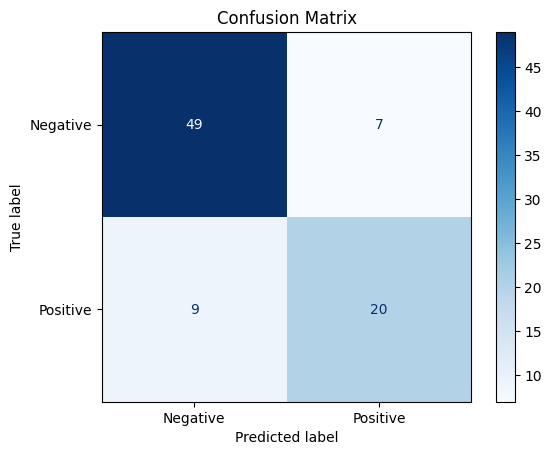


Classification Report:
              precision    recall  f1-score   support

    Negative       0.84      0.88      0.86        56
    Positive       0.74      0.69      0.71        29

    accuracy                           0.81        85
   macro avg       0.79      0.78      0.79        85
weighted avg       0.81      0.81      0.81        85

Number of selected features: 76
Shape of SHAP values: (250, 76)


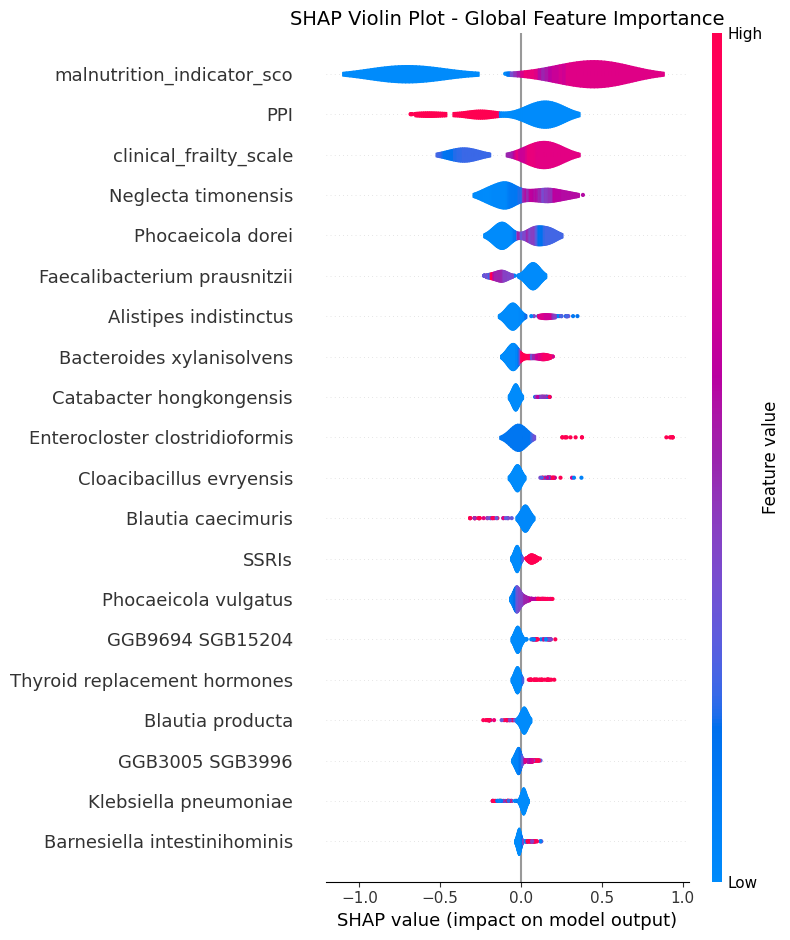

Overlap bacteria found: {'Phocaeicola_vulgatus', 'GGB3005_SGB3996', 'Phocaeicola_massiliensis', 'Evtepia_gabavorous', 'Phocaeicola_dorei', 'Neglecta_timonensis', 'Bilophila_wadsworthia', 'Bacteroides_uniformis', 'Longicatena_caecimuris', 'Blautia_producta', 'Collinsella_aerofaciens', 'Acidaminococcus_intestini', 'Bacteroides_ovatus', 'Clostridia_bacterium_UC5_1_1D1', 'Flavonifractor_plautii', 'Dialister_invisus', 'Roseburia_faecis', 'Blautia_faecis', 'Alistipes_putredinis', 'GGB9694_SGB15204', 'Blautia_wexlerae', 'GGB3433_SGB4573', 'Klebsiella_pneumoniae', 'GGB9694_SGB15201', 'Alistipes_onderdonkii', 'Bacteroides_xylanisolvens', 'Bacteroides_thetaiotaomicron', 'Bacteroides_cellulosilyticus', 'Parabacteroides_distasonis', 'Erysipelatoclostridium_ramosum', 'Clostridiaceae_bacterium', 'Lachnospiraceae_bacterium', 'Clostridia_bacterium', 'Clostridium_scindens', 'Alistipes_finegoldii', 'Ruthenibacterium_lactatiformans', 'GGB9712_SGB15244', 'Sellimonas_intestinalis', 'Tyzzerella_nexilis', 'P

In [14]:
import optuna
from optuna.samplers import TPESampler
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    roc_curve, roc_auc_score, f1_score, accuracy_score, confusion_matrix, 
    classification_report, ConfusionMatrixDisplay
)

from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from sklearn.model_selection import train_test_split
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

# Constants and Configuration
print(f"Experiment number: {experiment_number} | Seed number: {seed}")
# seed = experiment_seed  # Replace with your experiment seed
test_size = 0.25
gpu_device = "hist"

# Function to check for overlaps between train and test data
def check_for_overlap(train_data, test_data):
    """
    Checks for overlapping Sample ID and study_id between train and test datasets.
    """
    # Check for overlapping Study IDs
    overlap_study_ids = set(train_data["study_id"]) & set(test_data["study_id"])
    if overlap_study_ids:
        print(f"Overlap Study ID found: {overlap_study_ids}")
    else:
        print("No overlap Study ID found.")

    # Check for overlapping Sample IDs
    overlap_sample_ids = set(train_data["Sample ID"]) & set(test_data["Sample ID"])
    if overlap_sample_ids:
        print(f"Overlap Sample ID found: {overlap_sample_ids}")
    else:
        print("No overlap Sample ID found.")

def check_for_bacteria(list_a, list_b):
    """
    Checks for overlapping bactertia from list_a and list list_b database and predicted bacteria.
    """
    # Check for overlapping Study IDs
    list_a = [item.replace(" ", "_") for item in list_a]
    list_b = [item.replace(" ", "_") for item in list_b]
    
    overlap_bacteria = set(list_a) & set(list_b)
    if overlap_bacteria:
        print(f"Overlap bacteria found: {overlap_bacteria}")
    else:
        print("No overlap bacteria found.")
    return overlap_bacteria

        
def preprocess_data(df, columns_to_drop, test_size, seed):
    # Split study IDs into train/test sets
    study_labels = df.groupby("study_id")["Alzheimers"].max().reset_index()
    train_ids, test_ids = train_test_split(
        study_labels["study_id"],
        test_size=test_size,
        stratify=study_labels["Alzheimers"],
        random_state=seed,
    )
    
    train_data = df[df["study_id"].isin(train_ids)].copy()
    test_data = df[df["study_id"].isin(test_ids)].copy()

    # Check for overlaps
    check_for_overlap(train_data, test_data)
    
    # Select feature columns
    feature_columns = [col for col in df.columns if col not in columns_to_drop]

    # Convert feature columns to float64 to ensure compatibility
    train_data[feature_columns] = train_data[feature_columns].astype(np.float64)
    test_data[feature_columns] = test_data[feature_columns].astype(np.float64)

    # Normalize the feature columns
    scaler = StandardScaler()
    train_data.loc[:, feature_columns] = scaler.fit_transform(train_data[feature_columns])
    test_data.loc[:, feature_columns] = scaler.transform(test_data[feature_columns])

    return train_data, test_data, feature_columns

# Function to compute class weights
def compute_weights(y_train):
    class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
    scale_pos_weight = class_weights[1] / class_weights[0]
    return scale_pos_weight

# Define Optuna Objective Function
def objective(trial, X_train, y_train, scale_pos_weight, seed):
    print(f"Seed in the model {seed} on Device {device}")
    # Feature selection parameters
    threshold = trial.suggest_categorical('threshold', ['median', 'mean', '0.5*mean', '1.5*mean', 'very_low'])
    max_features = trial.suggest_int('max_features', 1, X_train.shape[1])
    norm_order = trial.suggest_int('norm_order', 1, 2)
    threshold_value = -1e10 if threshold == 'very_low' else threshold

    # Feature selection
    selector = SelectFromModel(
        estimator=XGBClassifier(
            objective='binary:logistic',
            eval_metric='logloss',
            scale_pos_weight= scale_pos_weight,
            random_state=seed,
            tree_method=gpu_device, 
            device=device
        ),
        threshold=threshold_value,
        max_features=max_features,
        norm_order=norm_order
    )
    
    selector.fit(X_train, y_train)
    X_train_selected = selector.transform(X_train)

    # Define XGBoost parameters
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': scale_pos_weight,
        'seed': seed,
        'tree_method': gpu_device,
        'device': device
    }

    # Cross-validation
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)
    f1_scores = []
    for train_idx, val_idx in skf.split(X_train_selected, y_train):
        X_train_fold, X_val_fold = X_train_selected[train_idx], X_train_selected[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        dtrain = xgb.DMatrix(X_train_fold, label=y_train_fold)
        dval = xgb.DMatrix(X_val_fold, label=y_val_fold)
        model = xgb.train(
            params=params,
            dtrain=dtrain,
            num_boost_round=trial.suggest_int("n_estimators", 50, 300),
            evals=[(dtrain, 'train'), (dval, 'eval')],
            early_stopping_rounds=50,
            verbose_eval=False
        )
        y_val_pred = model.predict(dval)
        y_val_pred_binary = (y_val_pred >= 0.5).astype(int)
        f1_scores.append(f1_score(y_val_fold, y_val_pred_binary))
    return np.mean(f1_scores)

# Main Program
columns_to_drop = ["Sample ID", "study_id", "Alzheimers", "Date Sample", "age", "Dementia Other"] # "malnutrition_indicator_sco", "clinical_frailty_scale", "PPI", 

train_data, test_data, feature_columns = preprocess_data(clinical_microbiome_df, columns_to_drop, test_size, seed)
X_train = deepcopy(train_data[feature_columns].values)
y_train = np.array(train_data["Alzheimers"].values)
X_test = deepcopy(test_data[feature_columns].values)
y_test = np.array(test_data["Alzheimers"].values)
scale_pos_weight = compute_weights(y_train)

# Run Optuna Optimization
study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=seed))
study.optimize(lambda trial: objective(trial, X_train, y_train, scale_pos_weight, seed), n_trials=100)

# Best Parameters
best_params = study.best_params
print("Best Parameters:", best_params)

# Apply Final Model
final_selector = SelectFromModel(
    estimator=XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=seed,
        tree_method=gpu_device,
        device=device,
        scale_pos_weight=scale_pos_weight
    ),
    
    threshold=-1e10 if best_params['threshold'] == 'very_low' else best_params['threshold'],
    max_features=best_params['max_features'],
    norm_order=best_params['norm_order']
)

final_selector.fit(X_train, y_train)
X_train_selected = final_selector.transform(X_train)
X_test_selected = final_selector.transform(X_test)

# Train Final Model
final_model_params = {
    **{k: v for k, v in best_params.items() if k not in ['threshold', 'norm_order', 'max_features', 'n_estimators']},
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'scale_pos_weight': scale_pos_weight,
    'seed': seed,
    'tree_method': gpu_device,
    'device': device
}

dtrain_final = xgb.DMatrix(X_train_selected, label=y_train)
dtest_final = xgb.DMatrix(X_test_selected)

final_model = xgb.train(
    params=final_model_params,
    dtrain=dtrain_final,
    num_boost_round=best_params['n_estimators'],
)

# Predictions and Evaluation
y_test_pred = final_model.predict(dtest_final)
y_test_pred_binary = (y_test_pred >= 0.5).astype(int)
auc = roc_auc_score(y_test, y_test_pred)
accuracy = accuracy_score(y_test, y_test_pred_binary)
f1 = f1_score(y_test, y_test_pred_binary)
conf_matrix = confusion_matrix(y_test, y_test_pred_binary)

print("\nTest Metrics:")
print(f"ROC AUC: {auc}\nAccuracy: {accuracy}\nF1 Score: {f1}\nConfusion Matrix:\n{conf_matrix}")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(y_test, y_test_pred_binary, target_names=["Negative", "Positive"])
print("\nClassification Report:")
print(report)

# Extract feature names for selected features
selected_feature_names = [feature_columns[i] for i in final_selector.get_support(indices=True)]
print(f"Number of selected features: {len(selected_feature_names)}")

# Step 1: Initialize SHAP explainer
explainer = shap.Explainer(final_model, X_train_selected)

# Step 2: Compute SHAP values
shap_values = explainer(X_train_selected, check_additivity=False)

# Ensure SHAP values are in the correct shape for processing
print(f"Shape of SHAP values: {shap_values.values.shape}")  # Check the shape

# Truncate each feature name to a maximum of 30 characters
max_len = 40
selected_feature_names = [
    feature[:max_len] if len(feature) > max_len else feature  # Truncate if longer than 30 characters
    for feature in selected_feature_names
]

# Verify the selected feature names align with the SHAP values
assert len(selected_feature_names) == X_train_selected.shape[1], "Mismatch in feature names and SHAP input dimensions."

# Generate SHAP summary plot with corrected feature names
plt.figure(figsize=(20, 10))  # Increased width for a wider plot
plt.title("SHAP Violin Plot - Global Feature Importance", fontsize=14)

# Create summary plot with corrected feature names
shap.summary_plot(
    shap_values.values,  # SHAP values
    X_train_selected,  # Input data
    feature_names=selected_feature_names,  # Correct feature names
    max_display=20,  # Limit to top 20 features
    plot_type="violin"  # Violin plot with colors
)
plt.show()

bacteria_fount = check_for_bacteria(bacteria_df.species_name.tolist(),selected_feature_names)

In [15]:
auc

np.float64(0.8220443349753694)

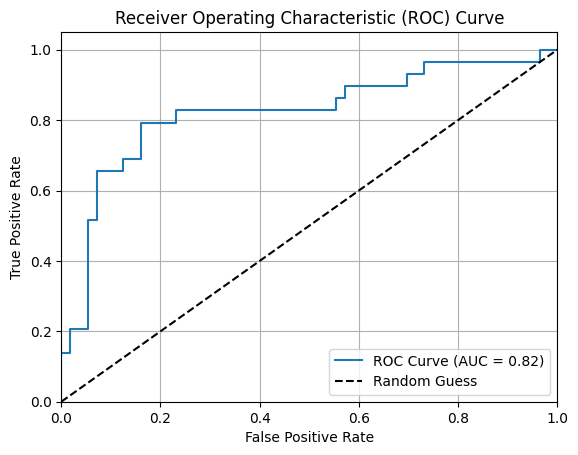

In [16]:
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')  # Dashed diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [17]:
accuracy

0.8117647058823529

In [18]:
f1

np.float64(0.7142857142857143)

In [19]:
conf_matrix

array([[49,  7],
       [ 9, 20]])

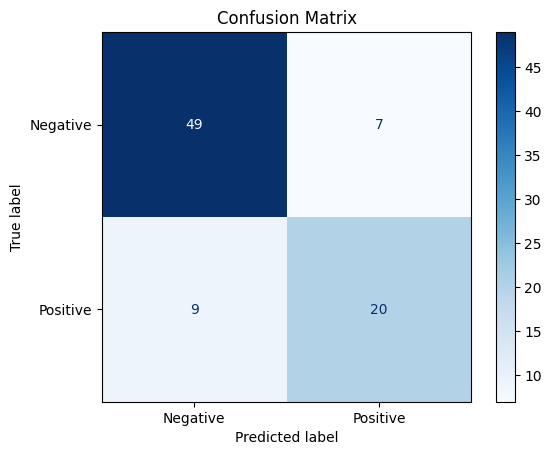

In [20]:
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

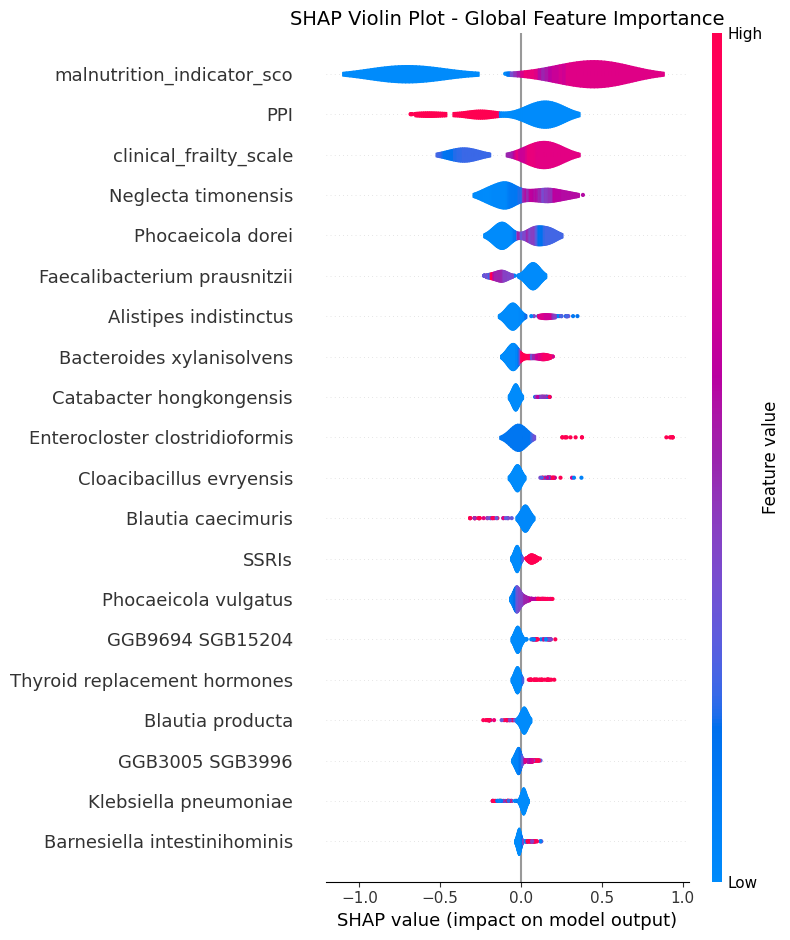

Overlap bacteria found: {'Phocaeicola_vulgatus', 'GGB3005_SGB3996', 'Phocaeicola_massiliensis', 'Evtepia_gabavorous', 'Phocaeicola_dorei', 'Neglecta_timonensis', 'Bilophila_wadsworthia', 'Bacteroides_uniformis', 'Longicatena_caecimuris', 'Blautia_producta', 'Collinsella_aerofaciens', 'Acidaminococcus_intestini', 'Bacteroides_ovatus', 'Clostridia_bacterium_UC5_1_1D1', 'Flavonifractor_plautii', 'Dialister_invisus', 'Roseburia_faecis', 'Blautia_faecis', 'Alistipes_putredinis', 'GGB9694_SGB15204', 'Blautia_wexlerae', 'GGB3433_SGB4573', 'Klebsiella_pneumoniae', 'GGB9694_SGB15201', 'Alistipes_onderdonkii', 'Bacteroides_xylanisolvens', 'Bacteroides_thetaiotaomicron', 'Bacteroides_cellulosilyticus', 'Parabacteroides_distasonis', 'Erysipelatoclostridium_ramosum', 'Clostridiaceae_bacterium', 'Lachnospiraceae_bacterium', 'Clostridia_bacterium', 'Clostridium_scindens', 'Alistipes_finegoldii', 'Ruthenibacterium_lactatiformans', 'GGB9712_SGB15244', 'Sellimonas_intestinalis', 'Tyzzerella_nexilis', 'P

In [21]:
# Verify the selected feature names align with the SHAP values
assert len(selected_feature_names) == X_train_selected.shape[1], "Mismatch in feature names and SHAP input dimensions."

# Generate SHAP summary plot with corrected feature names
plt.figure(figsize=(20, 10))  # Increased width for a wider plot
plt.title("SHAP Violin Plot - Global Feature Importance", fontsize=14)

# Create summary plot with corrected feature names
shap.summary_plot(
    shap_values.values,  # SHAP values
    X_train_selected,  # Input data
    feature_names=selected_feature_names,  # Correct feature names
    max_display=20,  # Limit to top 20 features
    plot_type="violin"  # Violin plot with colors
)
plt.show()

bacteria_fount = check_for_bacteria(bacteria_df.species_name.tolist(),selected_feature_names)

Shape of SHAP values: (250, 76)


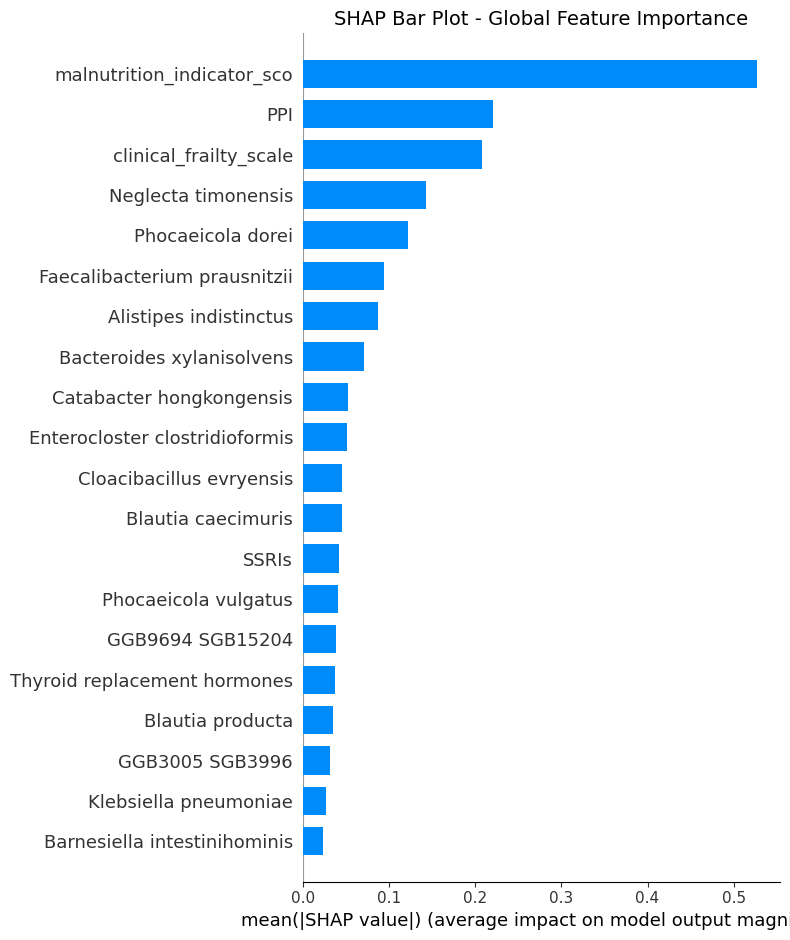

Overlap bacteria found: {'Phocaeicola_vulgatus', 'GGB3005_SGB3996', 'Phocaeicola_massiliensis', 'Evtepia_gabavorous', 'Phocaeicola_dorei', 'Neglecta_timonensis', 'Bilophila_wadsworthia', 'Bacteroides_uniformis', 'Longicatena_caecimuris', 'Blautia_producta', 'Collinsella_aerofaciens', 'Acidaminococcus_intestini', 'Bacteroides_ovatus', 'Clostridia_bacterium_UC5_1_1D1', 'Flavonifractor_plautii', 'Dialister_invisus', 'Roseburia_faecis', 'Blautia_faecis', 'Alistipes_putredinis', 'GGB9694_SGB15204', 'Blautia_wexlerae', 'GGB3433_SGB4573', 'Klebsiella_pneumoniae', 'GGB9694_SGB15201', 'Alistipes_onderdonkii', 'Bacteroides_xylanisolvens', 'Bacteroides_thetaiotaomicron', 'Bacteroides_cellulosilyticus', 'Parabacteroides_distasonis', 'Erysipelatoclostridium_ramosum', 'Clostridiaceae_bacterium', 'Lachnospiraceae_bacterium', 'Clostridia_bacterium', 'Clostridium_scindens', 'Alistipes_finegoldii', 'Ruthenibacterium_lactatiformans', 'GGB9712_SGB15244', 'Sellimonas_intestinalis', 'Tyzzerella_nexilis', 'P

In [22]:
# Ensure SHAP values are in the correct shape for processing
print(f"Shape of SHAP values: {shap_values.values.shape}")  # Check the shape

# Truncate each feature name to a maximum of 30 characters
max_len = 40
selected_feature_names = [
    feature[:max_len] if len(feature) > max_len else feature  # Truncate if longer than 30 characters
    for feature in selected_feature_names
]

# Verify the selected feature names align with the SHAP values
assert len(selected_feature_names) == X_train_selected.shape[1], "Mismatch in feature names and SHAP input dimensions."

# Generate SHAP summary plot with corrected feature names
plt.figure(figsize=(20, 10))  # Increased width for a wider plot
plt.title("SHAP Bar Plot - Global Feature Importance", fontsize=14)

# Create summary plot with corrected feature names
shap.summary_plot(
    shap_values.values,  # SHAP values
    X_train_selected,  # Input data
    feature_names=selected_feature_names,  # Correct feature names
    max_display=20,  # Limit to top 20 features
    plot_type="bar"  # Violin plot with colors
)
plt.show()

bacteria_fount = check_for_bacteria(bacteria_df.species_name.tolist(),selected_feature_names)

In [23]:
measures = ["xgboost", seed, experiment_number, accuracy, auc, f1]

# Create a DataFrame with appropriate column names
columns = ["Model", "Seed", "Experiment_Number", "Accuracy", "AUC", "F1_Score"]
measures_df = pd.DataFrame([measures], columns=columns)
measures_df

,Model,Seed,Experiment_Number,Accuracy,AUC,F1_Score
0,xgboost,442822283,9,0.811765,0.822044,0.714286


In [24]:
output_path = "output"
measures_path = f"{output_path}{os.sep}xgboost_experiment{experiment_number:02d}_measures.csv"
if output_path and not os.path.exists(output_path):
    os.makedirs(output_path)
measures_path

'output/xgboost_experiment09_measures.csv'

In [25]:
measures_df.to_csv(measures_path, index=False)